In [1]:
using Plots; pyplot(size = (600,400))
using StatPlots

In [2]:
include("src/CHMM.jl")

chmm_em! (generic function with 1 method)

In [7]:
K = 4
D = 2

# doesn't line up in format with NGSIM data (specifically, no time/frame aspect)
model = rand_chmm(K, D)
(X, Z, trajptr, pairs_full) = rand_trajs(model, 
    T_range=100:1_000, N_pairs=1_500)
num_trajs = length(trajptr) - 1
num_obs = size(X, 2)

1641682

In [15]:
max_wiggle = 10
num_pairs = round(Int, length(pairs_full) / 1)
pairs = zeros(Int, 4, num_pairs)
pairs_to_keep = randperm(length(pairs_full))[1:num_pairs]

for (i, ind) in enumerate(pairs_to_keep)
    c1, c2 = pairs_full[ind]
    s_wiggle = rand(1:max_wiggle)
    e_wiggle = rand(1:max_wiggle)

    r1 = get_trajectory_range(trajptr, c1)
    pairs[1, i] = first(r1) + s_wiggle
    pairs[2, i] = last(r1) - e_wiggle

    r2 = get_trajectory_range(trajptr, c2)
    pairs[3, i] = first(r2) + s_wiggle
    pairs[4, i] = last(r2) - e_wiggle
end

## EM

In [10]:
curr = chmm_from_data(X, K)
orig = deepcopy(curr)
suff = ChmmSuffStats(curr)
;

In [16]:
(curr, loglike_hist) = chmm_em!(curr, suff, X, trajptr, pairs; N_iters=50, print_every=5)
;

iteration      5:  -9809537.429
iteration     10:  -9780525.035
iteration     15:  -9779502.349
iteration     20:  -9779468.446
iteration     25:  -9779467.383



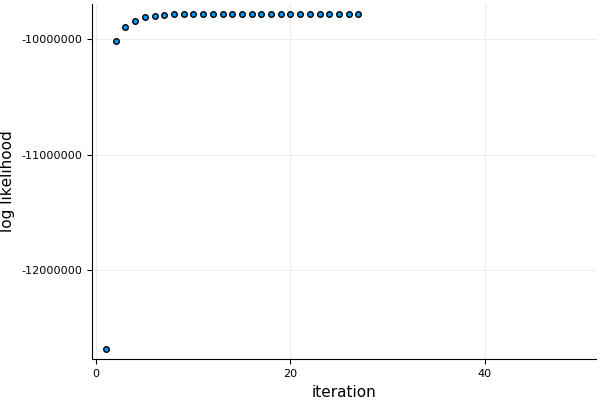

In [17]:
scatter(loglike_hist, legend=false)
ylabel!("log likelihood")
xlabel!("iteration")

In [21]:
@assert all( diff(filter(isfinite, loglike_hist)) .> 0 )


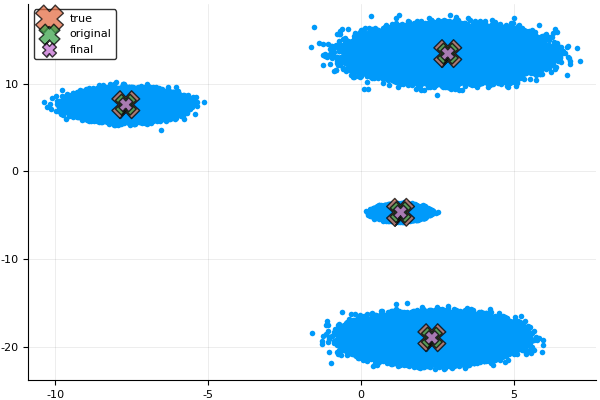

In [19]:
m = hcat(model.μs...)'
mo = hcat(orig.μs...)'
mhat = hcat(curr.μs...)'

scatter(X[1, :], X[2, :], label="", marker=(:circle, stroke(0)))
scatter!(m[:, 1], m[:, 2], marker=:X, ms=20, label="true", alpha=0.75)
scatter!(mo[:, 1], mo[:, 2], marker=:X, ms=15, label="original", alpha=0.75)
scatter!(mhat[:,1], mhat[:, 2], marker=:X, ms=10, label="final", alpha=0.75)

# Analysis

In [9]:
true_to_est = empty(Int, K)
for i in 1:K
    m = model.μs[i]
    r = map(mm -> norm(m .- mm), curr.μs)
    true_to_est[i] = indmin(r)
end
true_to_est_full = vec(outer(true_to_est))
;

## P

In [10]:
#
# factor true dist
#

P_true = copy(model.P)
P_single = zeros(K, K, K)

for i in 1:K
    for j in 1:i
        k = sub2ind((K, K), i, j)
        A = square_view(P_true, K, :, k)
        p1, p2 = estimate_outer_double(A)
        
        P_single[:, i, j] = p1        
        P_single[:, j, i] = p2
    end
end

In [11]:
#
# factor est
#

P_hat = curr.P[true_to_est_full, true_to_est_full]
P_single_hat = zeros(K, K, K)

for i in 1:K
    for j in 1:i
        k1 = sub2ind((K, K), i, j)
        k2 = sub2ind((K, K), j, i)
        A = square_view(P_hat, K, :, k1) + square_view(P_hat, K, :, k1)'
        p1, p2 = estimate_outer_double(A)
        
        P_single_hat[:, i, j] = p1        
        P_single_hat[:, j, i] = p2
    end
end

In [12]:
# full
(mean(P_true .- P_hat), std(P_true .- P_hat))

(0.02045202921187214, 0.1420441518790101)

In [13]:
# factored
(mean(P_single .- P_single_hat), std(P_single .- P_single_hat))

(-2.05596856412066e-17, 0.20951000004590498)


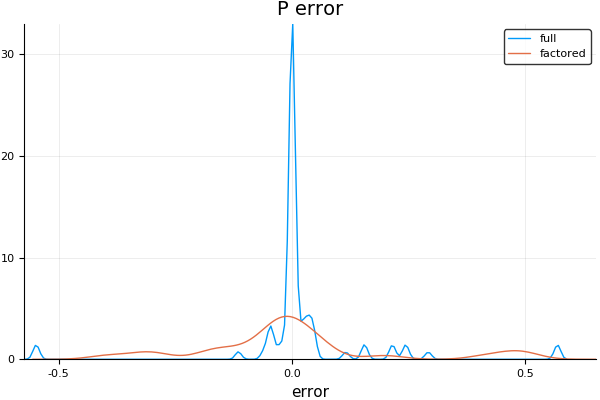

In [27]:
plot(vec(P_true .- P_hat), seriestype=:density, label="full")
plot!(vec(P_single .- P_single_hat), seriestype=:density, label="factored", xlabel="error")
title!("P error")

## π₀

In [15]:
p0_true = copy(model.π0)
p0_hat = copy( curr.π0[true_to_est_full] )
(mean(p0_true .- p0_hat), std(p0_true .- p0_hat))

(0.0038754327911052944, 0.06351688033833716)


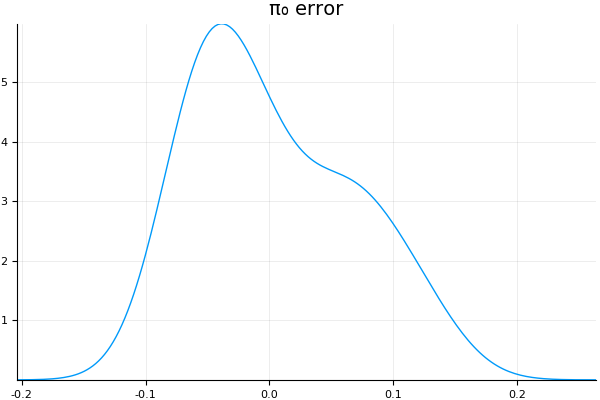

In [28]:
plot(vec(p0_true .- p0_hat), seriestype=:density, legend=false)
title!("π₀ error")

## μs

In [17]:
m_errs = [vec((model.μs[i] .- curr.μs[true_to_est[i]])./model.μs[i]) for i in 1:K]
hcat(m_errs ...)

2×3 Array{Float64,2}:
  5.9384e-5   -0.000309608  -3.06394e-5 
 -5.52661e-5   4.25172e-5    0.000227916


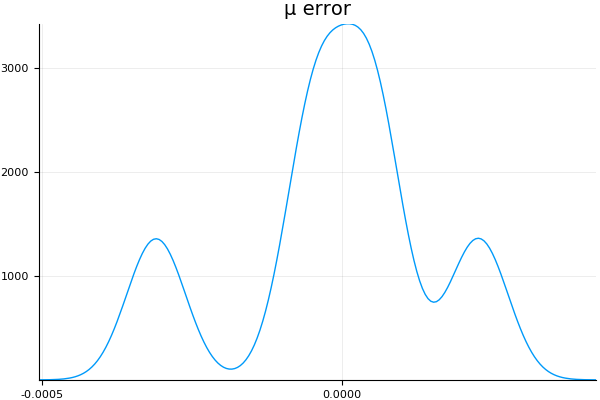

In [29]:
plot(vcat(m_errs...), seriestype=:density, legend=false)
title!("μ error")

## Σs

In [30]:
S_errs = [vec( model.Σs[i] .- curr.Σs[true_to_est[i]] ) for i in 1:K]
[map(mean, S_errs) map(std, S_errs)]

3×2 Array{Float64,2}:
 -0.00119095   0.00110673 
  0.000525872  0.000860243
  8.16153e-5   0.000629823


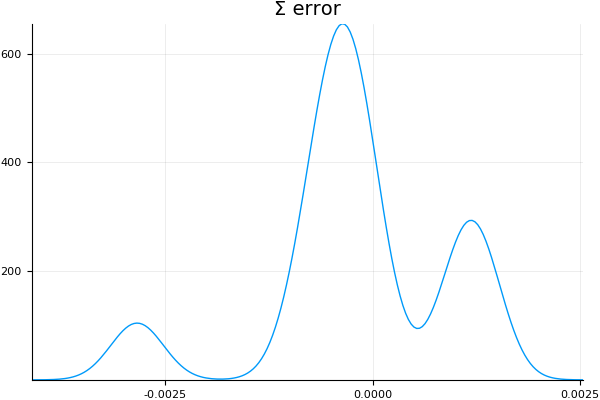

In [31]:
plot(vcat(S_errs...), seriestype=:density, legend=false)
title!("Σ error")